<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task3_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [1]:
%pip install thop

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

from torch.profiler import profile, ProfilerActivity, record_function
import torch.cuda.profiler as profiler

from thop import profile

# get rid of annoying log messages from thop
import logging
logging.getLogger("ptflops").setLevel(logging.WARNING)

## 1. Define your first network

In [3]:
# ResNet Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.silu(out)
        return out

class MobileNetV2Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(MobileNetV2Block, self).__init__()

        expand_ratio = 2
        hidden_dim = in_planes * expand_ratio

        self.conv = nn.Sequential(
            nn.Conv2d(in_planes, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),

            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=stride, padding=1,
                     groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),

            nn.Conv2d(hidden_dim, out_planes, 1, bias=False),
            nn.BatchNorm2d(out_planes)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return out

# https://arxiv.org/abs/2111.11418
class PoolFormerBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(PoolFormerBlock, self).__init__()

        expand_ratio = 2
        hidden_dim = in_planes * expand_ratio

        self.pool = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        )

        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.Conv2d(in_planes, hidden_dim, 1, bias=False),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, in_planes, 1, bias=False),
        )

        self.patchify = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.patchify = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=1, stride=stride, bias=False),
            )

    def forward(self, x):
        out = x
        out = self.pool(out) + out
        out = self.conv(out) + out
        out = self.patchify(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, bn_after=True):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.bn_after = bn_after

        # we utilize lazy in places to make it compatible with both CIFAR and MNIST

        self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if self.bn_after else None
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.LazyLinear(num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)) if self.bn_after else self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def MobileNetV2():
    return ResNet(MobileNetV2Block, [2, 2, 2, 2])

def PoolFormer():
    return ResNet(PoolFormerBlock, [2, 2, 2, 2])

## 2. Implement training loop and test function

In [4]:
# I put in quite a bit of extra stuff to profile/optimizing training
# since I have an interview coming where I need to do that

def train(model, device, train_loader, optimizer, scheduler, epoch, compile_mode):
    model.train()

    if compile_mode is not None:
        model.compile(compile_mode)

    running_loss = 0.0
    correct = 0
    total = 0
    loss_curve = []

    scaler = torch.amp.GradScaler("cuda")

    print_acc = False

    for epoch in tqdm.tqdm(range(epoch)):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()

          with torch.autocast(device_type="cuda", dtype=torch.float16):
              output = model(data)
              loss = F.cross_entropy(output, target)

          scaler.scale(loss).backward()

          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()

          if batch_idx % 100 == 0:
              loss_curve.append(loss.item())

              if print_acc:
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

      scheduler.step()



    return loss_curve

def test(model, device, test_loader, compile_mode):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    with torch.no_grad():
      model.eval()

      # This should force recompilation from training... I think
      if compile_mode is not None:
          model.compile(mode=compile_mode)

      running_loss = 0.0

      correct = 0
      total = 0

      total_latency = 0.0
      macs = 0

      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)

          start = torch.cuda.Event(enable_timing=True)
          end = torch.cuda.Event(enable_timing=True)

          with torch.autocast(device_type="cuda", dtype=torch.float16):
            # torch.compile warmup before collecting timing data
            if compile_mode is not None and batch_idx == 0:
              print("Warming up for torch.compile()...")
              for _ in range(3):
                  _ = model(data)

            start.record()
            output = model(data)
            end.record()

            loss = F.cross_entropy(output, target)

            if batch_idx == 0:
              # get a batch size of 1
              macs, params = profile(model, inputs=(data[:1], ), verbose=False)

          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

          running_loss += loss.item()

          # Measure latency
          torch.cuda.synchronize()
          total_latency += start.elapsed_time(end)

      print(f'Loss: {running_loss / len(test_loader):.4f}, Acc: {100.*correct/total:.2f}%, Latency: {total_latency / len(test_loader):.2f}ms, MACs: {macs / 1000000:.1f}M')


## 3. Dataset loading


In [5]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Dataset and DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)




## 4. Put Everything Together

MNIST: Loss: 0.0178, Acc: 99.54%

CIFAR: Loss: 0.4036, Acc: 87.25%

RUNNING TRAINING AND TESTING FOR BASE CONFIG MODEL:PoolFormer


100%|██████████| 1/1 [00:24<00:00, 24.97s/it]


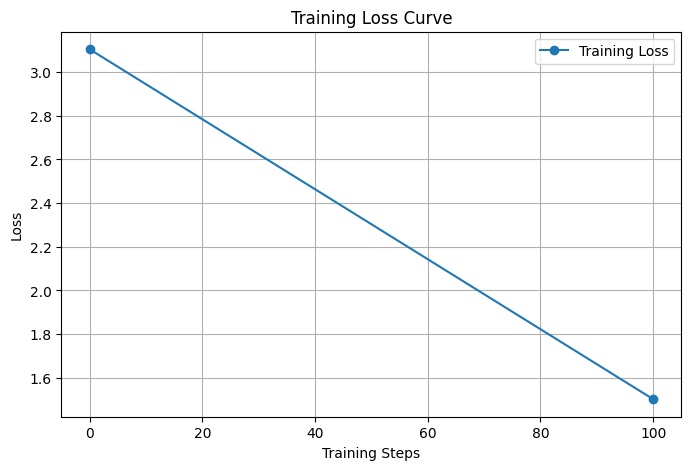

Loss: 1.5782, Acc: 44.97%, Latency: 4.39ms, MACs: 195.3M
FINISHED TRAINING AND TESTING FOR BASE CONFIG MODEL:PoolFormer




RUNNING TRAINING AND TESTING FOR BASE CONFIG MODEL:ResNet


100%|██████████| 1/1 [00:22<00:00, 22.35s/it]


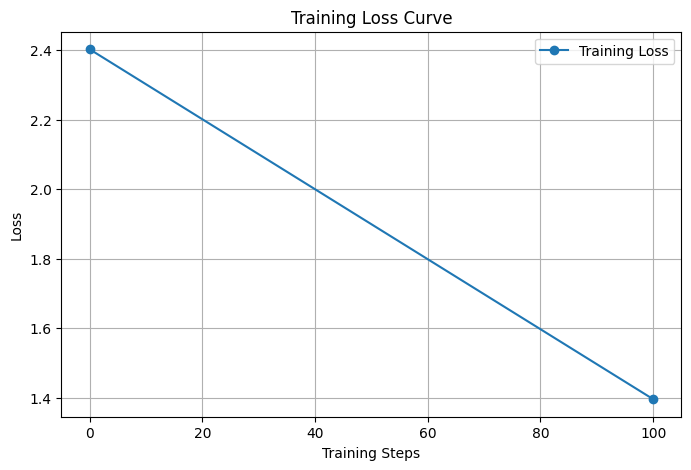

Loss: 1.4927, Acc: 45.79%, Latency: 3.44ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR BASE CONFIG MODEL:ResNet




RUNNING TRAINING AND TESTING FOR BASE CONFIG MODEL:MobileNetV2


100%|██████████| 1/1 [00:31<00:00, 31.76s/it]


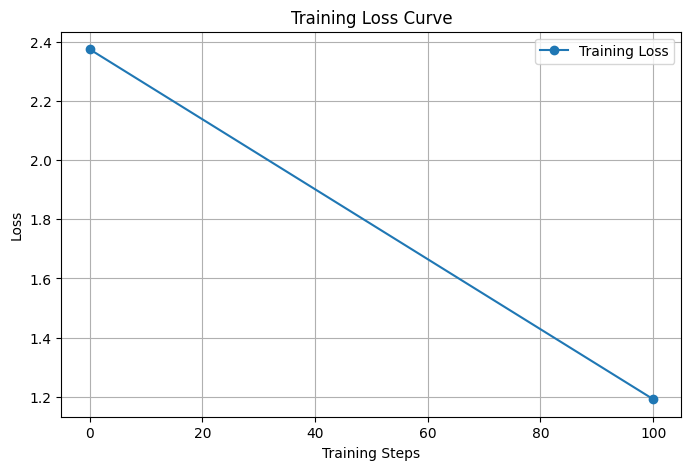

Loss: 1.1825, Acc: 59.95%, Latency: 18.15ms, MACs: 139.2M
FINISHED TRAINING AND TESTING FOR BASE CONFIG MODEL:MobileNetV2




The models meeting the accuracy requirements of this assignment are above.
And now we are done!


In [6]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries

device = torch.device("cuda")
def train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs, display_graph = False):
    model.to(device)

    # disable compilation to make the data collected more understandable
    compile_mode = None

    losses = train(model, device, train_loader, optimizer, scheduler, num_epochs, compile_mode)

    if display_graph:
        steps = [i * 100 for i in range(len(losses))]

        plt.figure(figsize=(8, 5))
        plt.plot(steps, losses, marker='o', label="Training Loss")

        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    # run test
    test(model, device, test_loader, compile_mode)



# idk I am not going to format this neatly
# iterate through various datasets to show that we meet the accuracy baselines


model_configs = [
    ("ResNet", ResNet18()),
    ("MobileNetV2", MobileNetV2()),
    ("PoolFormer", PoolFormer()),
]

for model_name, model in model_configs:
    num_epochs = 12

    config_str = f"BASE CONFIG MODEL:{model_name}"

    print("===================================================================")
    print(f"RUNNING TRAINING AND TESTING FOR {config_str}")

    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

    train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs, True)

    print(f"FINISHED TRAINING AND TESTING FOR {config_str}")
    print("===================================================================")


    print("\n\n\n")

print("The models meeting the accuracy requirements of this assignment are above.")

print("And now we are done!")